<a href="https://colab.research.google.com/github/pvdklei/modelsmakemodels/blob/master/sebas/Autoencoder_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import train
import utils

In [3]:
traintransform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

testtransform = traintransform

batch_size = 32
num_workers = 2

trainset = datasets.CIFAR10("/data/cifar10/train", train=True, transform=traintransform, download=True)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

testset = datasets.CIFAR10("/data/cifar10/test", train=False, transform=testtransform, download=True)
testloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
imiter = iter(trainloader)
images, _ = next(imiter)
image = images[0]
images.shape


torch.Size([32, 3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


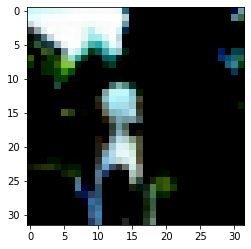

In [5]:
def showimage(image):
    image = image.detach().numpy()
    image = image.transpose((1, 2, 0))
    plt.imshow(image)
showimage(torchvision.utils.make_grid(images[0]))


In [6]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.drop = nn.Dropout(0.2)

        self.conv1 = nn.Conv2d(3, 12, kernel_size=4, stride=2, padding = 1)
        self.conv2 = nn.Conv2d(12, 24, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(24, 48, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        return x
        
enc = Encoder()
enc(images).shape

torch.Size([32, 48, 4, 4])

In [7]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.drop = nn.Dropout(0.2)

        self.conv1 = nn.ConvTranspose2d(48, 24, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(24, 12, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose2d(12, 3, kernel_size=4, stride=2, padding=1)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv3(x))
        return x

decoder = Decoder()
decoder(enc(images)).shape

torch.Size([32, 3, 32, 32])

In [8]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

autoenc = AutoEncoder()
autoenc(images).shape

torch.Size([32, 3, 32, 32])

In [9]:
model = AutoEncoder()
model

AutoEncoder(
  (encoder): Encoder(
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (drop): Dropout(p=0.2, inplace=False)
    (conv1): Conv2d(3, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(12, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(24, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (decoder): Decoder(
    (drop): Dropout(p=0.2, inplace=False)
    (conv1): ConvTranspose2d(48, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): ConvTranspose2d(24, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): ConvTranspose2d(12, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

In [10]:
state_dict = torch.load("checkpoint.model")
model.load_state_dict(state_dict)

<All keys matched successfully>

In [11]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(48*4*4, 10) 

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        return x

mod = Classifier()
mod(enc(images)).shape

torch.Size([32, 10])

In [12]:
class AutoEncoder_classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.classifier = Classifier()
    def forward(self, x):
        with torch.no_grad():
            x = self.encoder(x)
        x = self.classifier(x)
        return x

class_enc = AutoEncoder_classifier()


In [13]:
model = AutoEncoder_classifier()
model

AutoEncoder_classifier(
  (encoder): Encoder(
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (drop): Dropout(p=0.2, inplace=False)
    (conv1): Conv2d(3, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(12, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(24, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (classifier): Classifier(
    (fc1): Linear(in_features=768, out_features=10, bias=True)
  )
)

In [14]:
state_dict = torch.load("checkpoint.model")

In [15]:
from torch.nn.parameter import Parameter
def load_my_state_dict(self, state_dict):

    own_state = self.state_dict()
    for name, param in state_dict.items():
        if name not in own_state:
              continue
        if isinstance(param, Parameter):
            # backwards compatibility for serialized parameters
            param = param.data
        own_state[name].copy_(param)
load_my_state_dict(model, state_dict)



In [16]:
def train(model, optimizer, trainloader, testloader, criterion=nn.CrossEntropyLoss(), epochs=5):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    print(device)

    lowest_testloss = np.Inf

    for epoch in range(epochs):

        # training
        trainloss = 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            out = model(images)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            trainloss += loss.item()
        print(f"Epoch {epoch}, Training loss: {trainloss/len(trainloader)}")

        # validation
        testloss = 0
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            with torch.no_grad():
                out = model(images)
                loss = criterion(out, labels)
                testloss += loss
        print(f"Epoch {epoch}, Validation loss: {testloss/len(testloader)}")
        


        lowest_testloss = testloss
    
    # final accuracy
    totacc = 0
    n = 0
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            out = model(images)
            topv, topi = torch.topk(out, 1, dim=1)
            labels.resize_(*topi.shape)
            eq = topi == labels
            acc = torch.mean(eq.type(torch.FloatTensor))
            totacc += acc.item()
            n += 1
    totacc = n
    print(f"The final total accuracy is: {totacc * 100}")

In [18]:
train(model, 
      optim.Adam(params=model.classifier.parameters(), lr=0.001),
      trainloader, 
      testloader, epochs=40)

cuda
Epoch 0, Training loss: 1.9344729619078047
Epoch 0, Validation loss: 1.871349573135376
Epoch 1, Training loss: 1.9415711998863245
Epoch 1, Validation loss: 1.8313673734664917
Epoch 2, Training loss: 1.9051649142592975
Epoch 2, Validation loss: 1.8893557786941528
Epoch 3, Training loss: 1.9309906576660605
Epoch 3, Validation loss: 1.8504259586334229
Epoch 4, Training loss: 1.9046103502799514
Epoch 4, Validation loss: 1.7836047410964966
Epoch 5, Training loss: 1.8981830642838091
Epoch 5, Validation loss: 1.9689297676086426
Epoch 6, Training loss: 1.8989581964142568
Epoch 6, Validation loss: 1.9044287204742432
Epoch 7, Training loss: 1.9197154187729017
Epoch 7, Validation loss: 1.9624512195587158
Epoch 8, Training loss: 1.8874044674600612
Epoch 8, Validation loss: 1.8700913190841675
Epoch 9, Training loss: 1.8951141053258953
Epoch 9, Validation loss: 1.8448433876037598
Epoch 10, Training loss: 1.8925918194245468
Epoch 10, Validation loss: 2.096052646636963
Epoch 11, Training loss: 1.

In [19]:
torch.save(model.state_dict(), 'checkpoint_auto_classifier.model')